In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import json
import os

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 
    
def show_img(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('on')
    plt.show()
    
def predict_malti(predictor, image_path, points):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    input_point = np.array([p for p in points])
    input_label = np.array([1 for p in points]) 
    masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
    masks.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(masks, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()

def OnMouse(event, x, y, flags, params):
    coordinates = params  # paramsとして渡されたリストを使って座標を保存
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, y)
        coordinates.append((x, y))


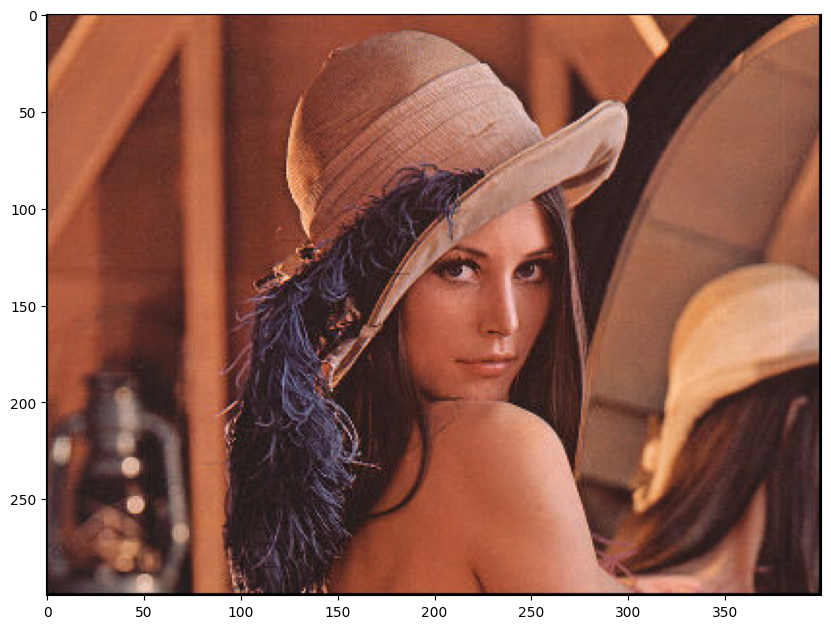

In [14]:
import os
from PIL import Image

# 画像が保存されているディレクトリのパス
image_dir = 'images/'

# ディレクトリ内のすべてのファイルを取得
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    show_img(image_path)

In [15]:
import sys
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

362 171
366 227
374 278
[(362, 171), (366, 227), (374, 278)]


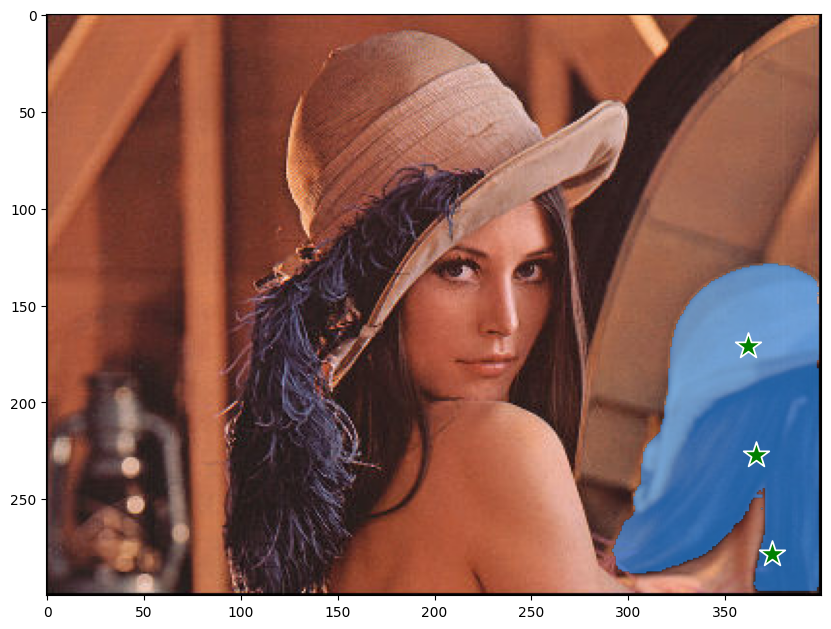

In [16]:
for image_file in image_files:
    coordinates = []  # 各画像ごとにリストを初期化
    image_path = os.path.join(image_dir, image_file)
    img = cv2.imread(image_path)
    cv2.imshow("image", img)
    cv2.setMouseCallback("image", OnMouse, coordinates)  # 座標リストをparamsとして渡す
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(coordinates)  # クリックされた座標が正しく表示される
    predict_malti(predictor, image_path, coordinates)